In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Use `cv2.COLOR_RGB2GRAY` if you've read in an image using `mpimg.imread()`. Use `cv2.COLOR_BGR2GRAY` if you've read in an image using `cv2.imread()`.

### Pipeline Steps:

1. Calibrate the incoming image to correct for camera distortion
1. Distort to bird's eye view
    1. Find the lane lines
    1. Find the closest and farthest points on each lane line
    1. Transform those points to be rectangular(?)
1. Use Sobel operator to detect roughly vertical lines?

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pdb
from pathlib import Path

## Camera Calibration Step

In [3]:
PATH = Path('./camera_cal/')
n_cols = 9
n_rows = 6
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

objp = np.zeros((n_cols*n_rows,3), np.float32)
objp[:,:2] = np.mgrid[0:n_cols,0:n_rows].T.reshape(-1,2)

In [4]:
for filename in list(PATH.iterdir()):
    img = plt.imread(filename)
    if img is None:
        print('ERROR')
        pdb.set_trace()
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (n_cols, n_rows), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        img = cv2.drawChessboardCorners(img, (n_cols, n_rows), corners, ret)
    else: 
        print('Unable to calibrate', filename)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

Unable to calibrate camera_cal\calibration1.jpg
Unable to calibrate camera_cal\calibration4.jpg
Unable to calibrate camera_cal\calibration5.jpg


Let's grab a warped looking file and run it through the calibration step...

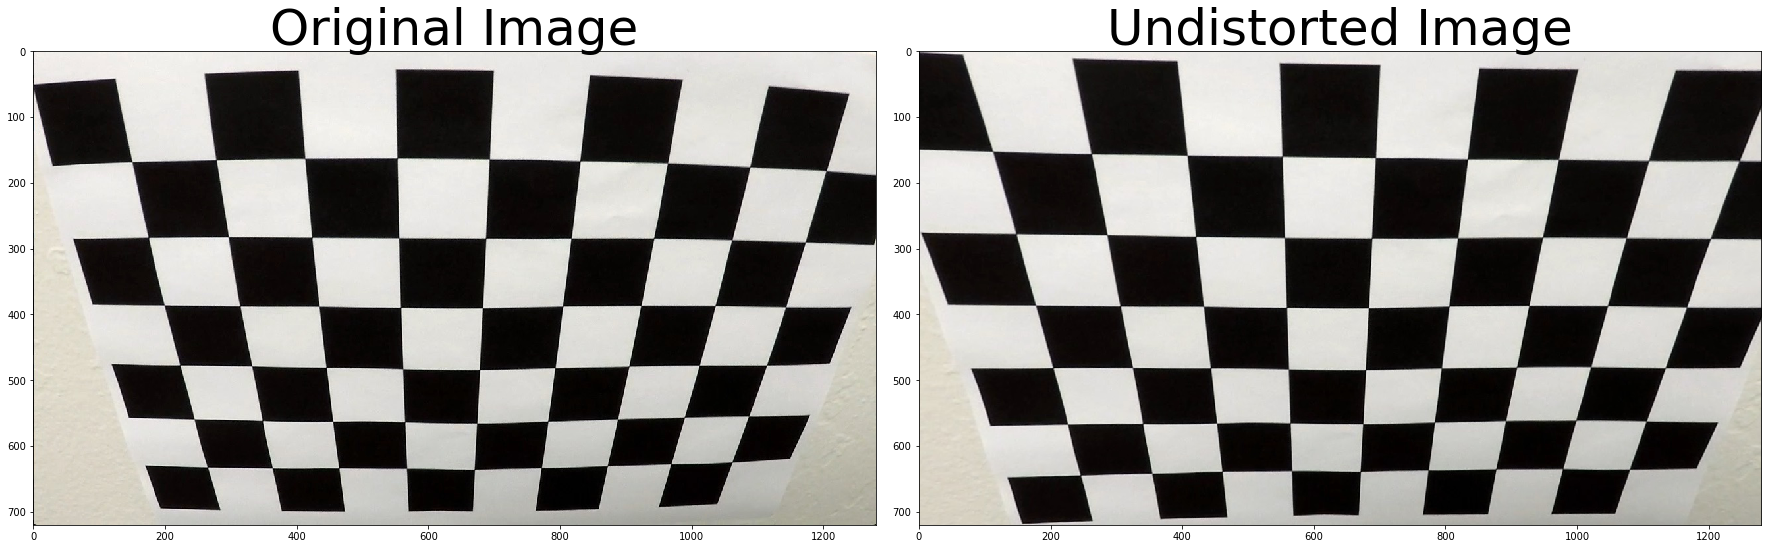

In [5]:
filename = list(PATH.iterdir())[11]
img = plt.imread(filename)
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
def calibrate_image(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

## Let's take a look at some of the test images

This code is very handy for displaying a few images easily

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


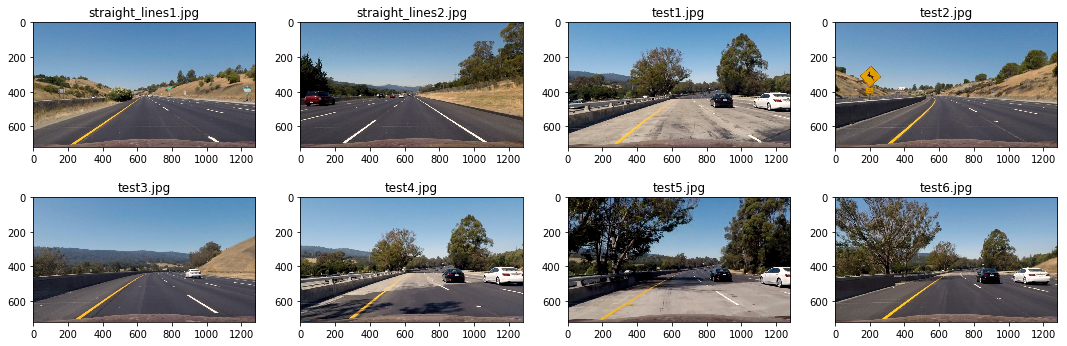

In [111]:
PATH = Path('./test_images/')
n_images = len(list(PATH.iterdir()))
row_len = 4

fig,axes=plt.subplots(n_images//row_len, row_len, figsize=(15,5))
for i, ax in enumerate(axes.flat):
    filename = list(PATH.iterdir())[i]
    img = plt.imread(filename)
    img = calibrate_image(img)
    if img is None:
        print('ERROR')
        pdb.set_trace()
    ax.imshow(img)
    ax.set_title(str(filename).split('\\')[-1])
plt.tight_layout()

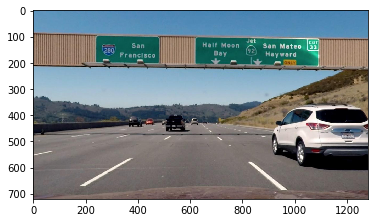

In [8]:
PATH = Path('./test_images/')
image = mpimg.imread(str(PATH/'test7.png'))
image = calibrate_image(image)
plt.imshow(image)

# Sobel Gradient

In [28]:
def abs_sobel_threshold(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Using mpimg.imread
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
       sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
       sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    max_sobel = np.max(abs_sobel)
    scaled_sobel = abs_sobel * 255 / max_sobel
    scaled_sobel = scaled_sobel.astype(np.uint8)
    # 5) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    s_binary = np.zeros_like(scaled_sobel)
    s_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
#     print(np.max(scaled_sobel))
    return s_binary

def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Using mpimg.imread
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # x gradient
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # y gradient

    # Calculate the magnitude 
    sum_sq = np.sqrt(sobel_x**2 + sobel_y**2)
    max_sobel = np.max(sum_sq)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = sum_sq * 255 / max_sobel
    scaled_sobel = scaled_sobel.astype(np.uint8)
    
    # Create a binary mask where mag thresholds are met
    post_threshold = np.zeros_like(scaled_sobel)
    post_threshold[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return post_threshold

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Using mpimg.imread
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # x gradient
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # y gradient
    # Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # Use arctan2 to calculate the direction of the gradient 
    atan = np.arctan2(abs_sobel_y, abs_sobel_x) # Element-wise arc tangent of y/x
    # Create a binary mask where direction thresholds are met
    post_threshold = np.zeros_like(atan)
    post_threshold[(atan >= thresh[0]) & (atan <= thresh[1])] = 1
    return post_threshold

In [155]:
### Parameters to tune
ksize = 7 # Choose a larger odd number to smooth gradient measurements
thresh = (50, 255)
mag_thresh = (50, 255)
dir_thresh = (0.8, 1.2)

def gradient_sobel(img):
    # Apply each of the thresholding functions
    gradx = abs_sobel_threshold(img, orient='x', sobel_kernel=ksize, thresh=thresh)
    grady = abs_sobel_threshold(img, orient='y', sobel_kernel=ksize, thresh=thresh)
    mag_binary = mag_threshold(img, sobel_kernel=ksize, mag_thresh=mag_thresh)
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=dir_thresh)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

## Let's test the functions we've developed:

It's clearly missing some areas (especially yellow lines), but not bad!

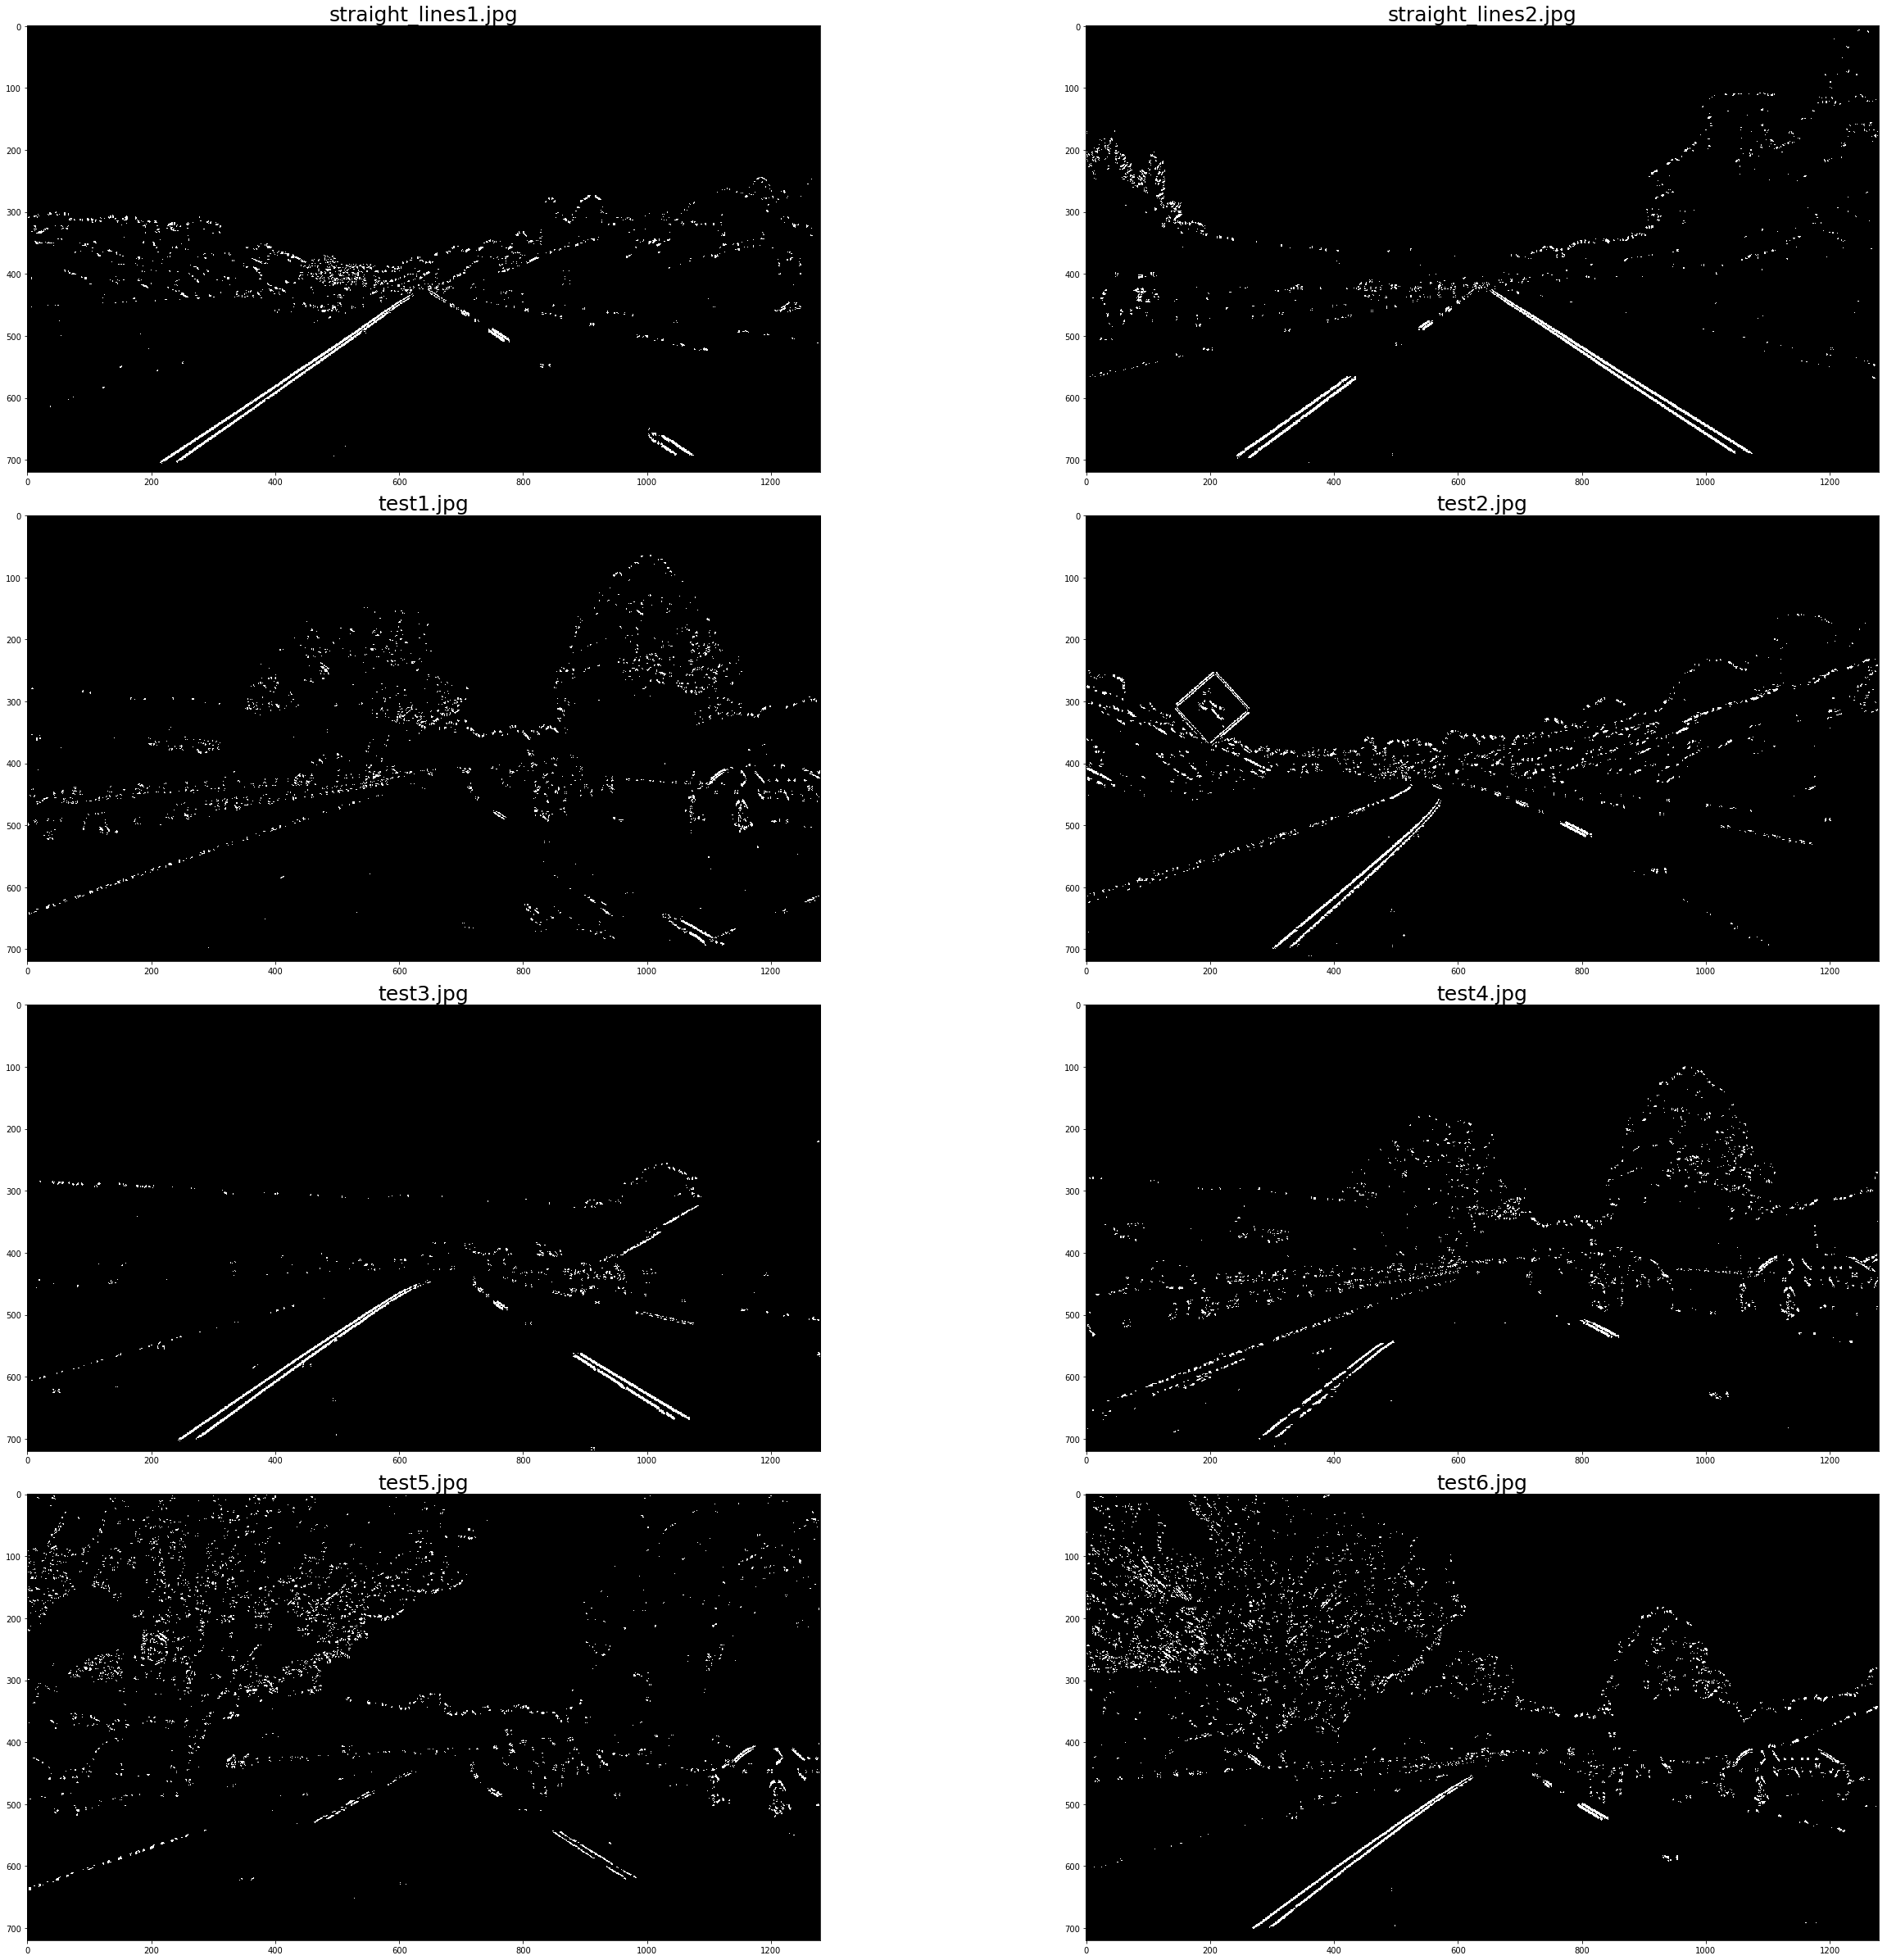

In [156]:
PATH = Path('./test_images/')
n_images = len(list(PATH.iterdir()))
row_len = 2
image_width = 80/row_len
image = None

fig,axes=plt.subplots(n_images//row_len, row_len, figsize=(image_width,image_width/1.2))
for i, ax in enumerate(axes.flat):
    filename = list(PATH.iterdir())[i]
    img = plt.imread(filename)
    if img is None:
        print('ERROR')
        pdb.set_trace()
        
    img = calibrate_image(img)
    img = gradient_sobel(img)

    ax.imshow(img, cmap='gray')
    ax.set_title(str(filename).split('\\')[-1], fontsize=25)
plt.tight_layout()

# HSL Color Space

In [176]:
### Parameters to tune
s_min = 200
s_max = 255
v_min = 200
v_max = 255

In [177]:
def color_transform(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_min) & (s_channel < s_max)] = 1
    
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > v_min) & (v_channel < v_max)] = 1
    
    out = np.zeros_like(s_channel)
    out[(s_binary == 1) & (v_binary == 1)] = 1
    return out

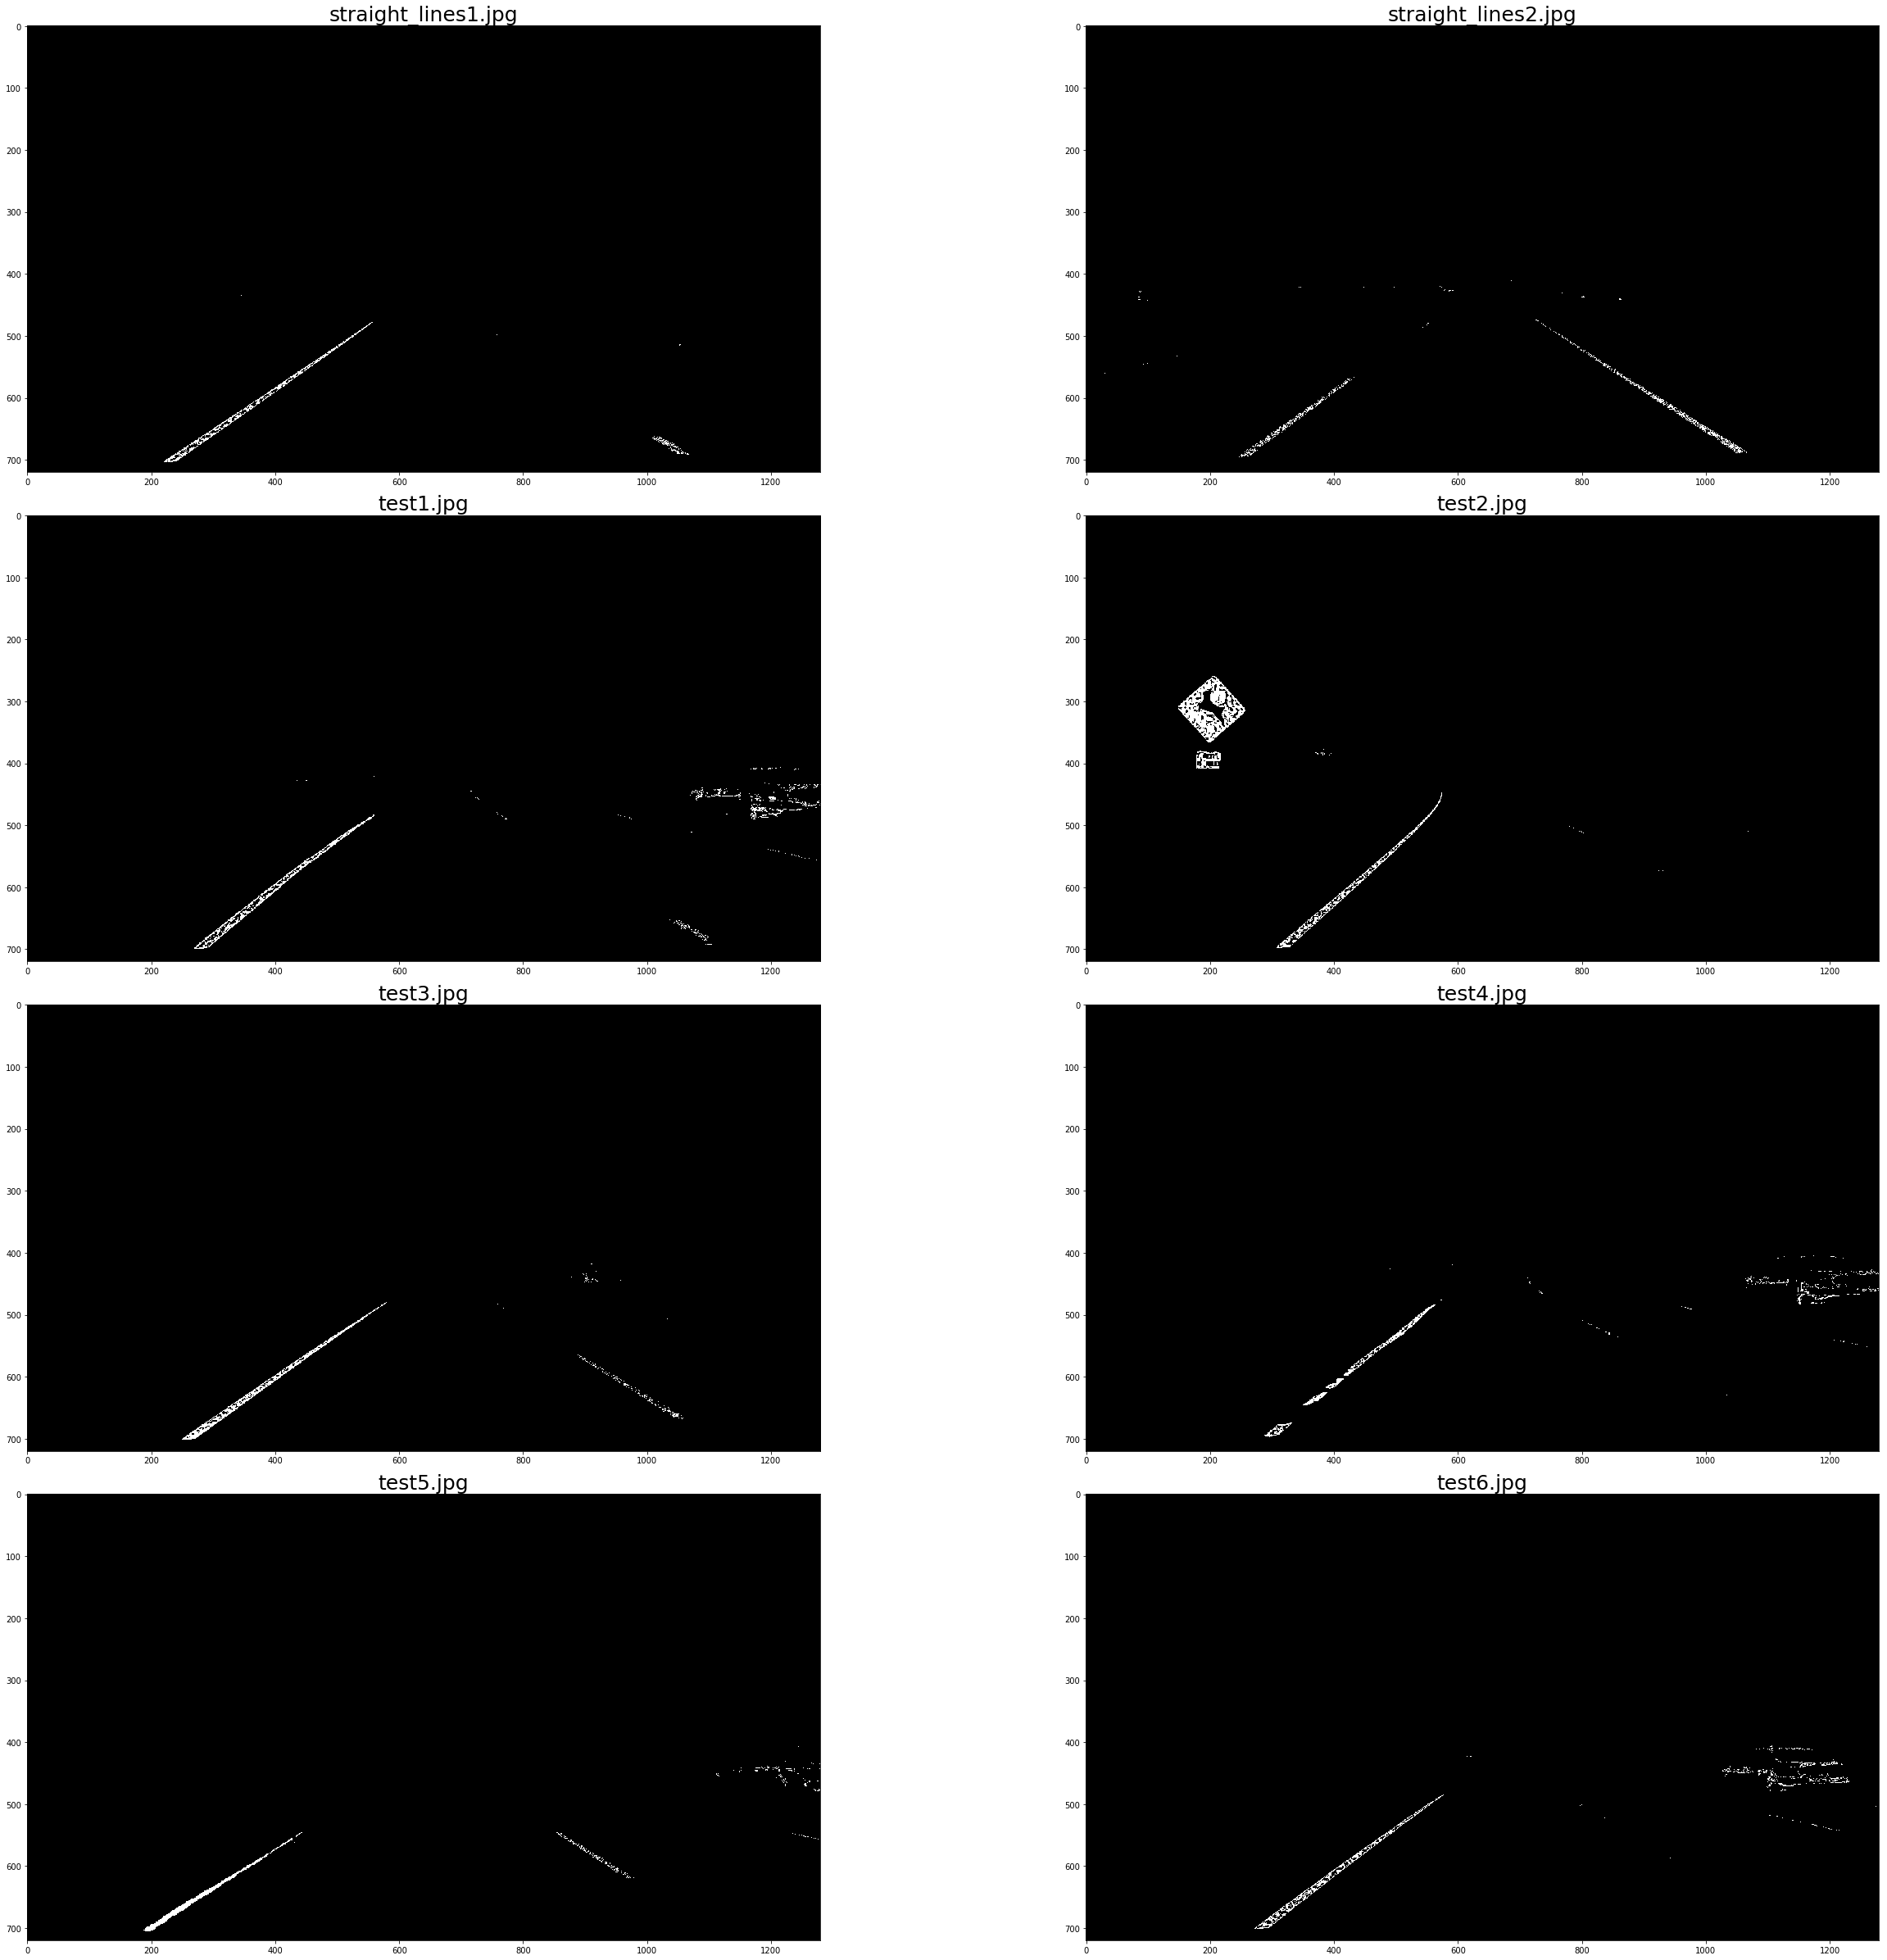

In [178]:
PATH = Path('./test_images/')
n_images = len(list(PATH.iterdir()))
# n_images = 4
row_len = 2
image_width = 80/row_len
image = None

fig,axes=plt.subplots(n_images//row_len, row_len, figsize=(image_width,image_width/1.2))
for i, ax in enumerate(axes.flat):
    filename = list(PATH.iterdir())[i]
    img = plt.imread(filename)
    if img is None:
        print('ERROR')
        pdb.set_trace()
        
    img = calibrate_image(img)
    img = color_transform(img)

    ax.imshow(img, cmap='gray')
    ax.set_title(str(filename).split('\\')[-1], fontsize=25)
plt.tight_layout()

# Test Gradient + Color Transform together

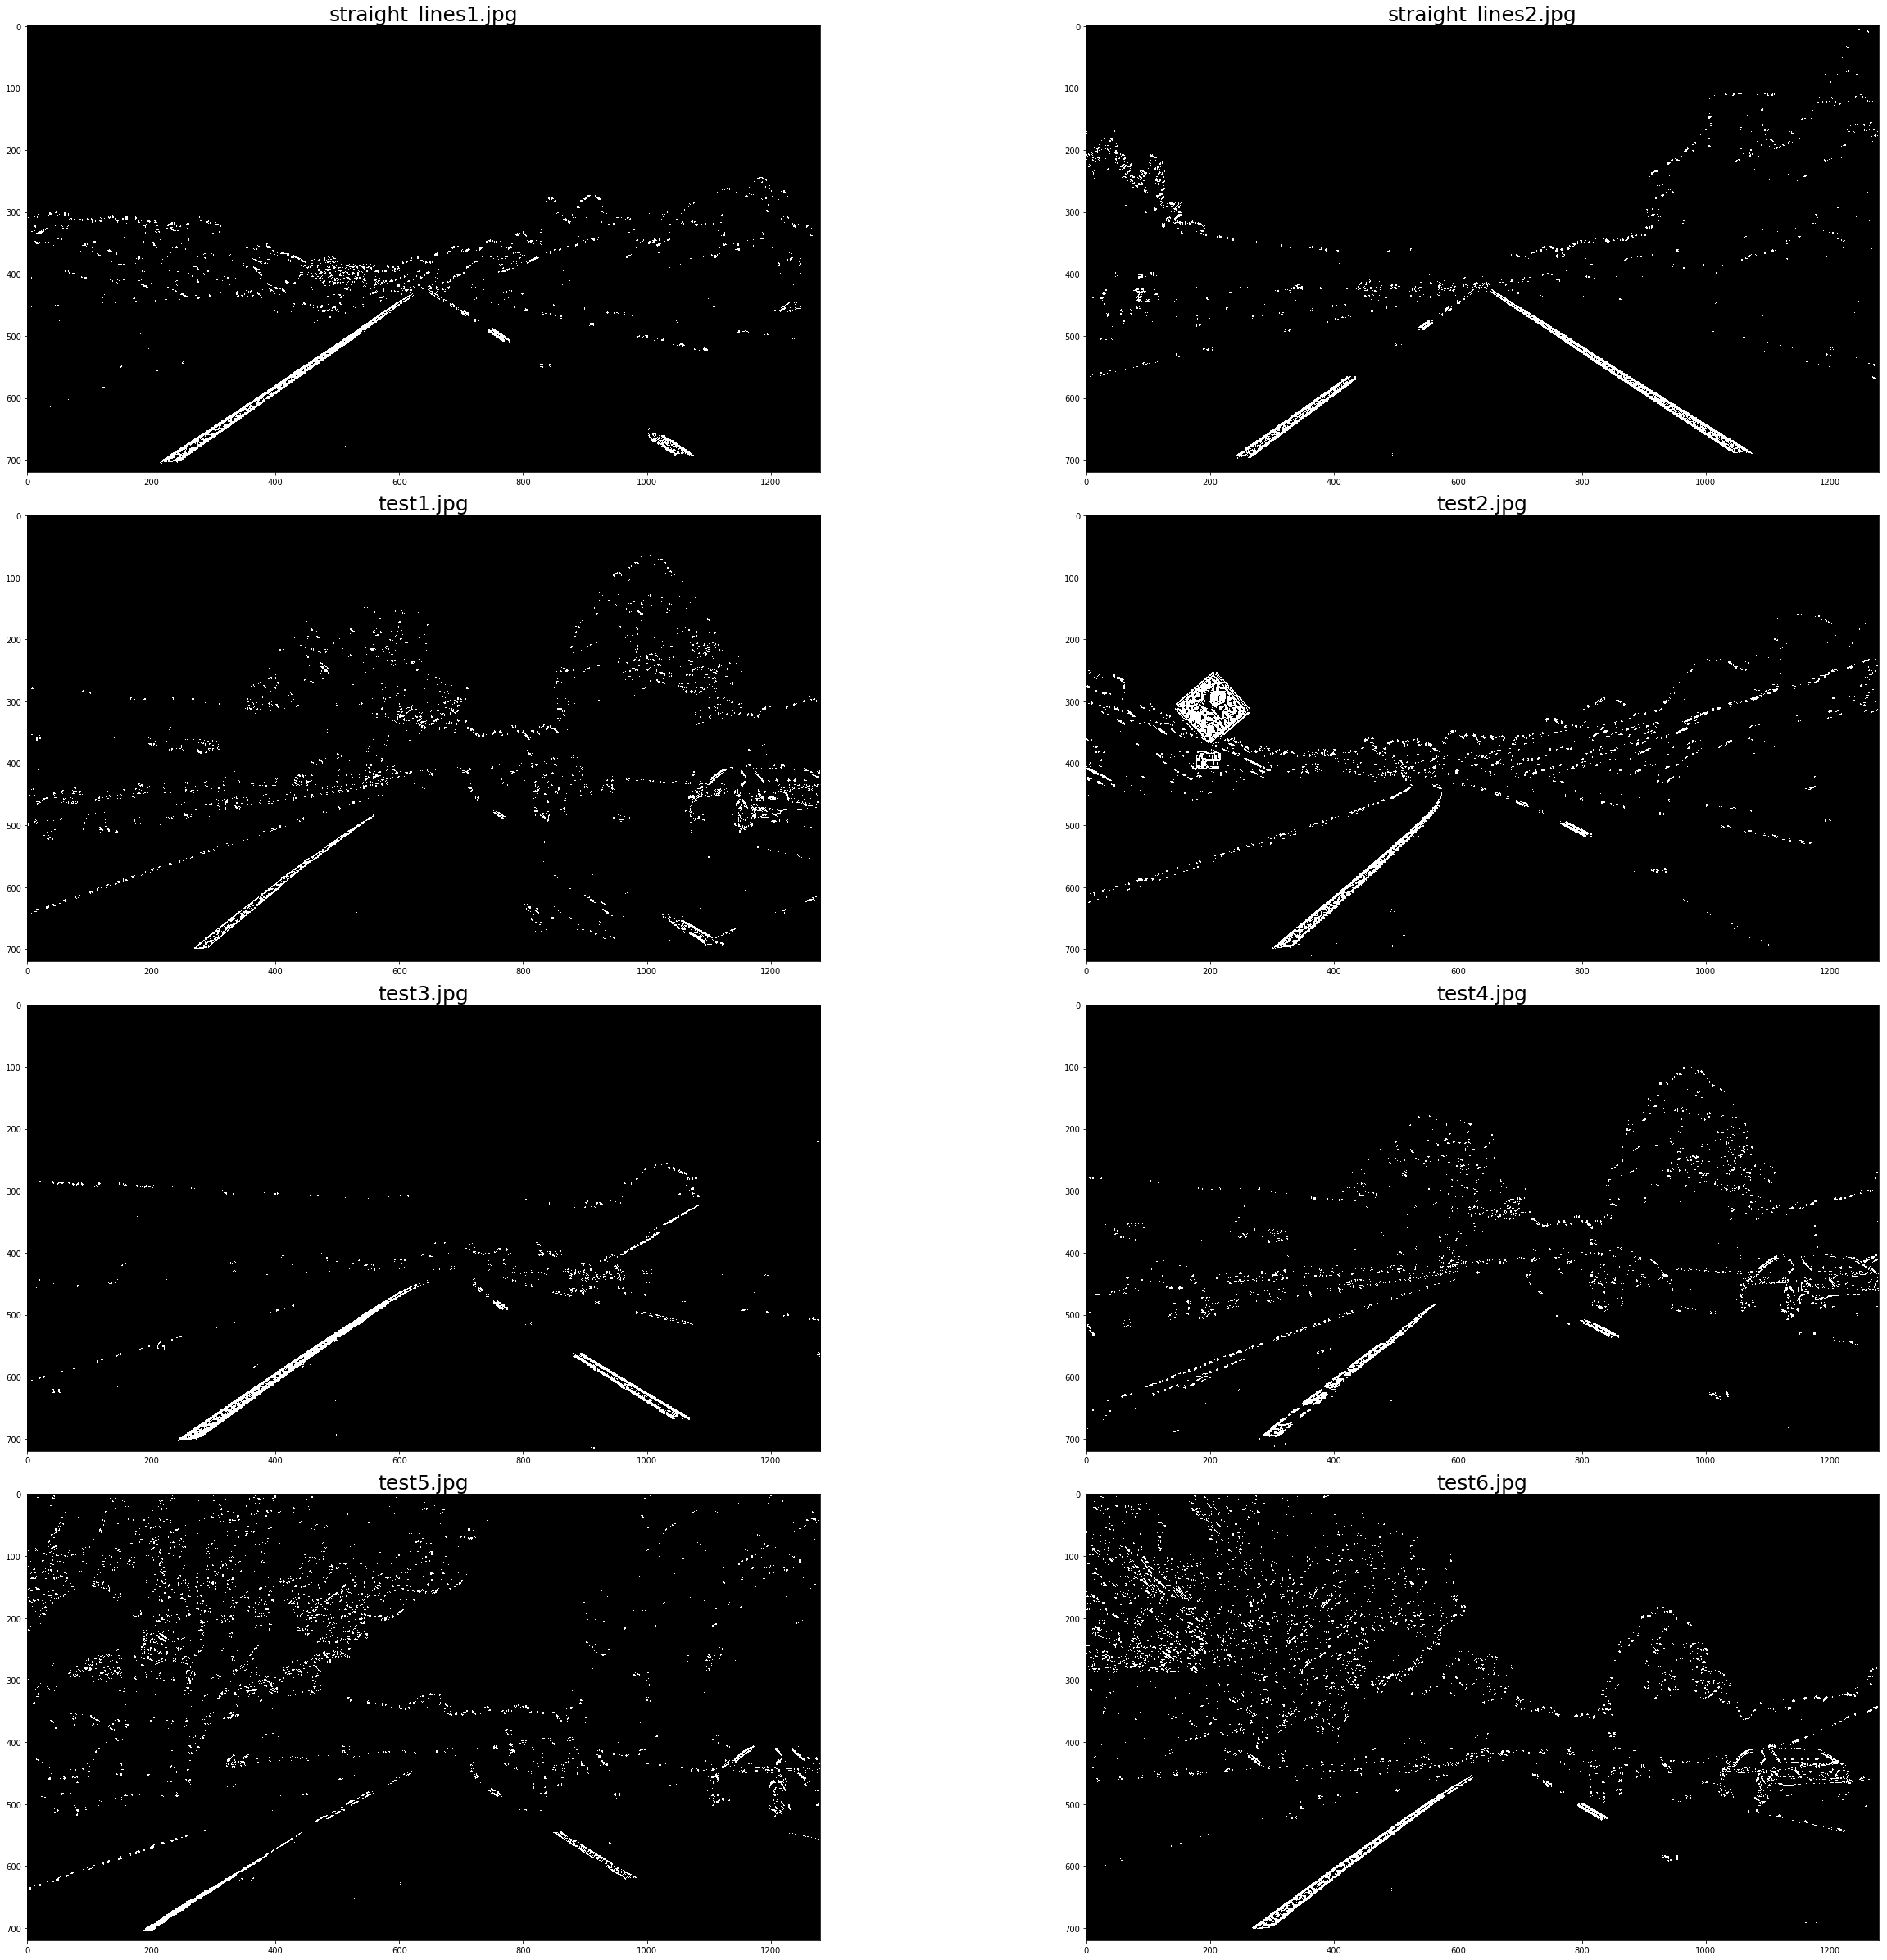

In [179]:
PATH = Path('./test_images/')
n_images = len(list(PATH.iterdir()))
row_len = 2
image_width = 80/row_len
image = None

fig, axes = plt.subplots(n_images//row_len, row_len, figsize=(image_width,image_width/1.2))
for i, ax in enumerate(axes.flat):
    filename = list(PATH.iterdir())[i]
    img = plt.imread(filename)
    if img is None:
        print('ERROR')
        pdb.set_trace()
        
    img = calibrate_image(img)
    grad = gradient_sobel(img)
    color = color_transform(img)
    
    img = np.zeros_like(color)
    img[(grad == 1) | (color == 1)] = 1
#     print(img.shape)
#     print(np.mean(img))

    ax.imshow(img, cmap='gray')
    ax.set_title(str(filename).split('\\')[-1], fontsize=25)
plt.tight_layout()

# Perspective Transform

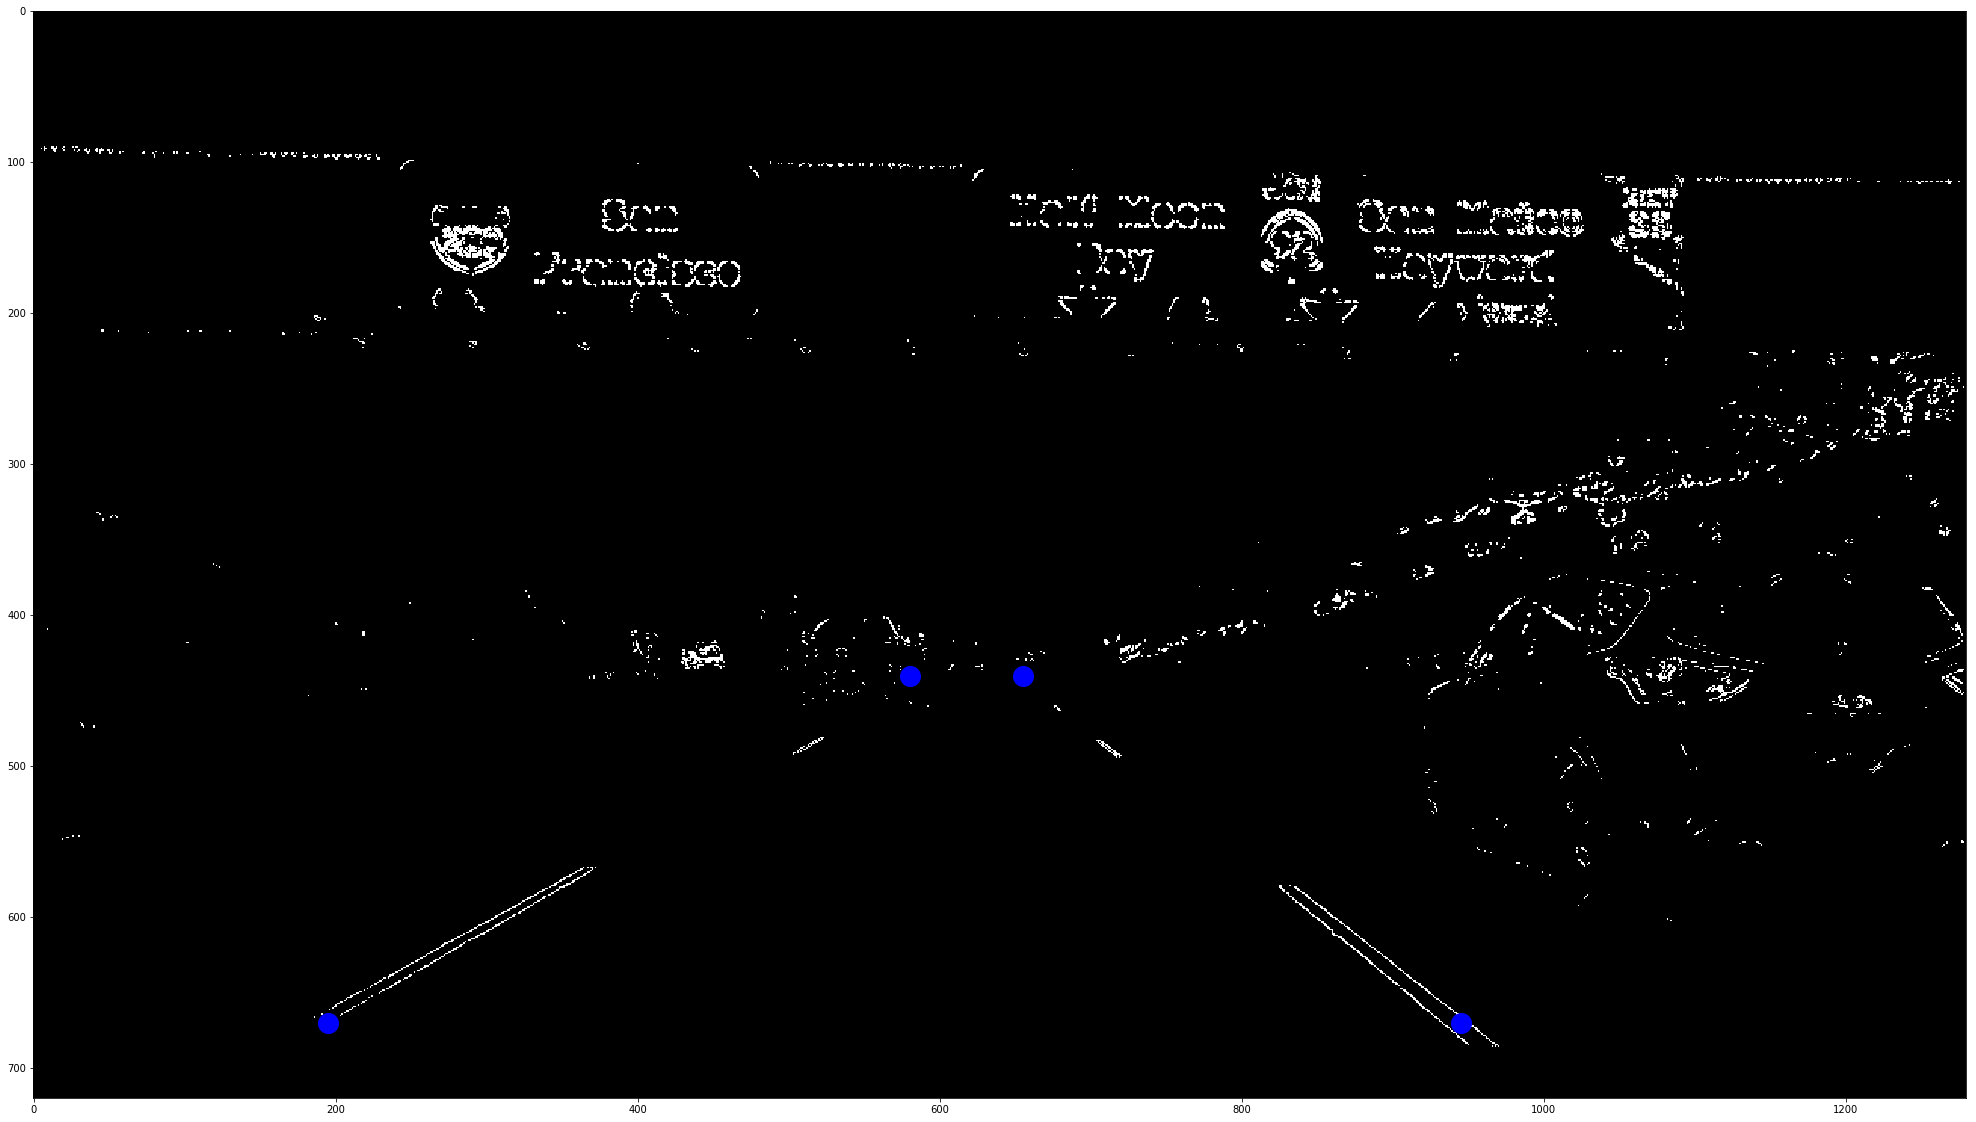

In [20]:
fig, ax = plt.subplots(figsize=(40, 20))
ax.imshow(combined_binary, cmap='gray')
src = np.float32(
[[580,440], # Top left
[655,440], # Top right
[195,670], # Bottom left
[945,670]])
for pt in src:
    plt.plot(*pt,'bo',markersize=20)

In [21]:
print(combined_binary.shape)

(720, 1280)


In [22]:
img_size = combined_binary.shape[::-1] # Width x Height instead of Height x Width
w = img_size[0]
h = img_size[1]

dst = np.float32(
[[0.2*w, 0.2*h],
[0.8*w, 0.2*h],
[0.2*w, 0.8*h],
[0.8*w, 0.8*h]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)

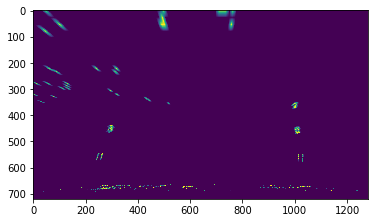

In [23]:
plt.imshow(warped)

9


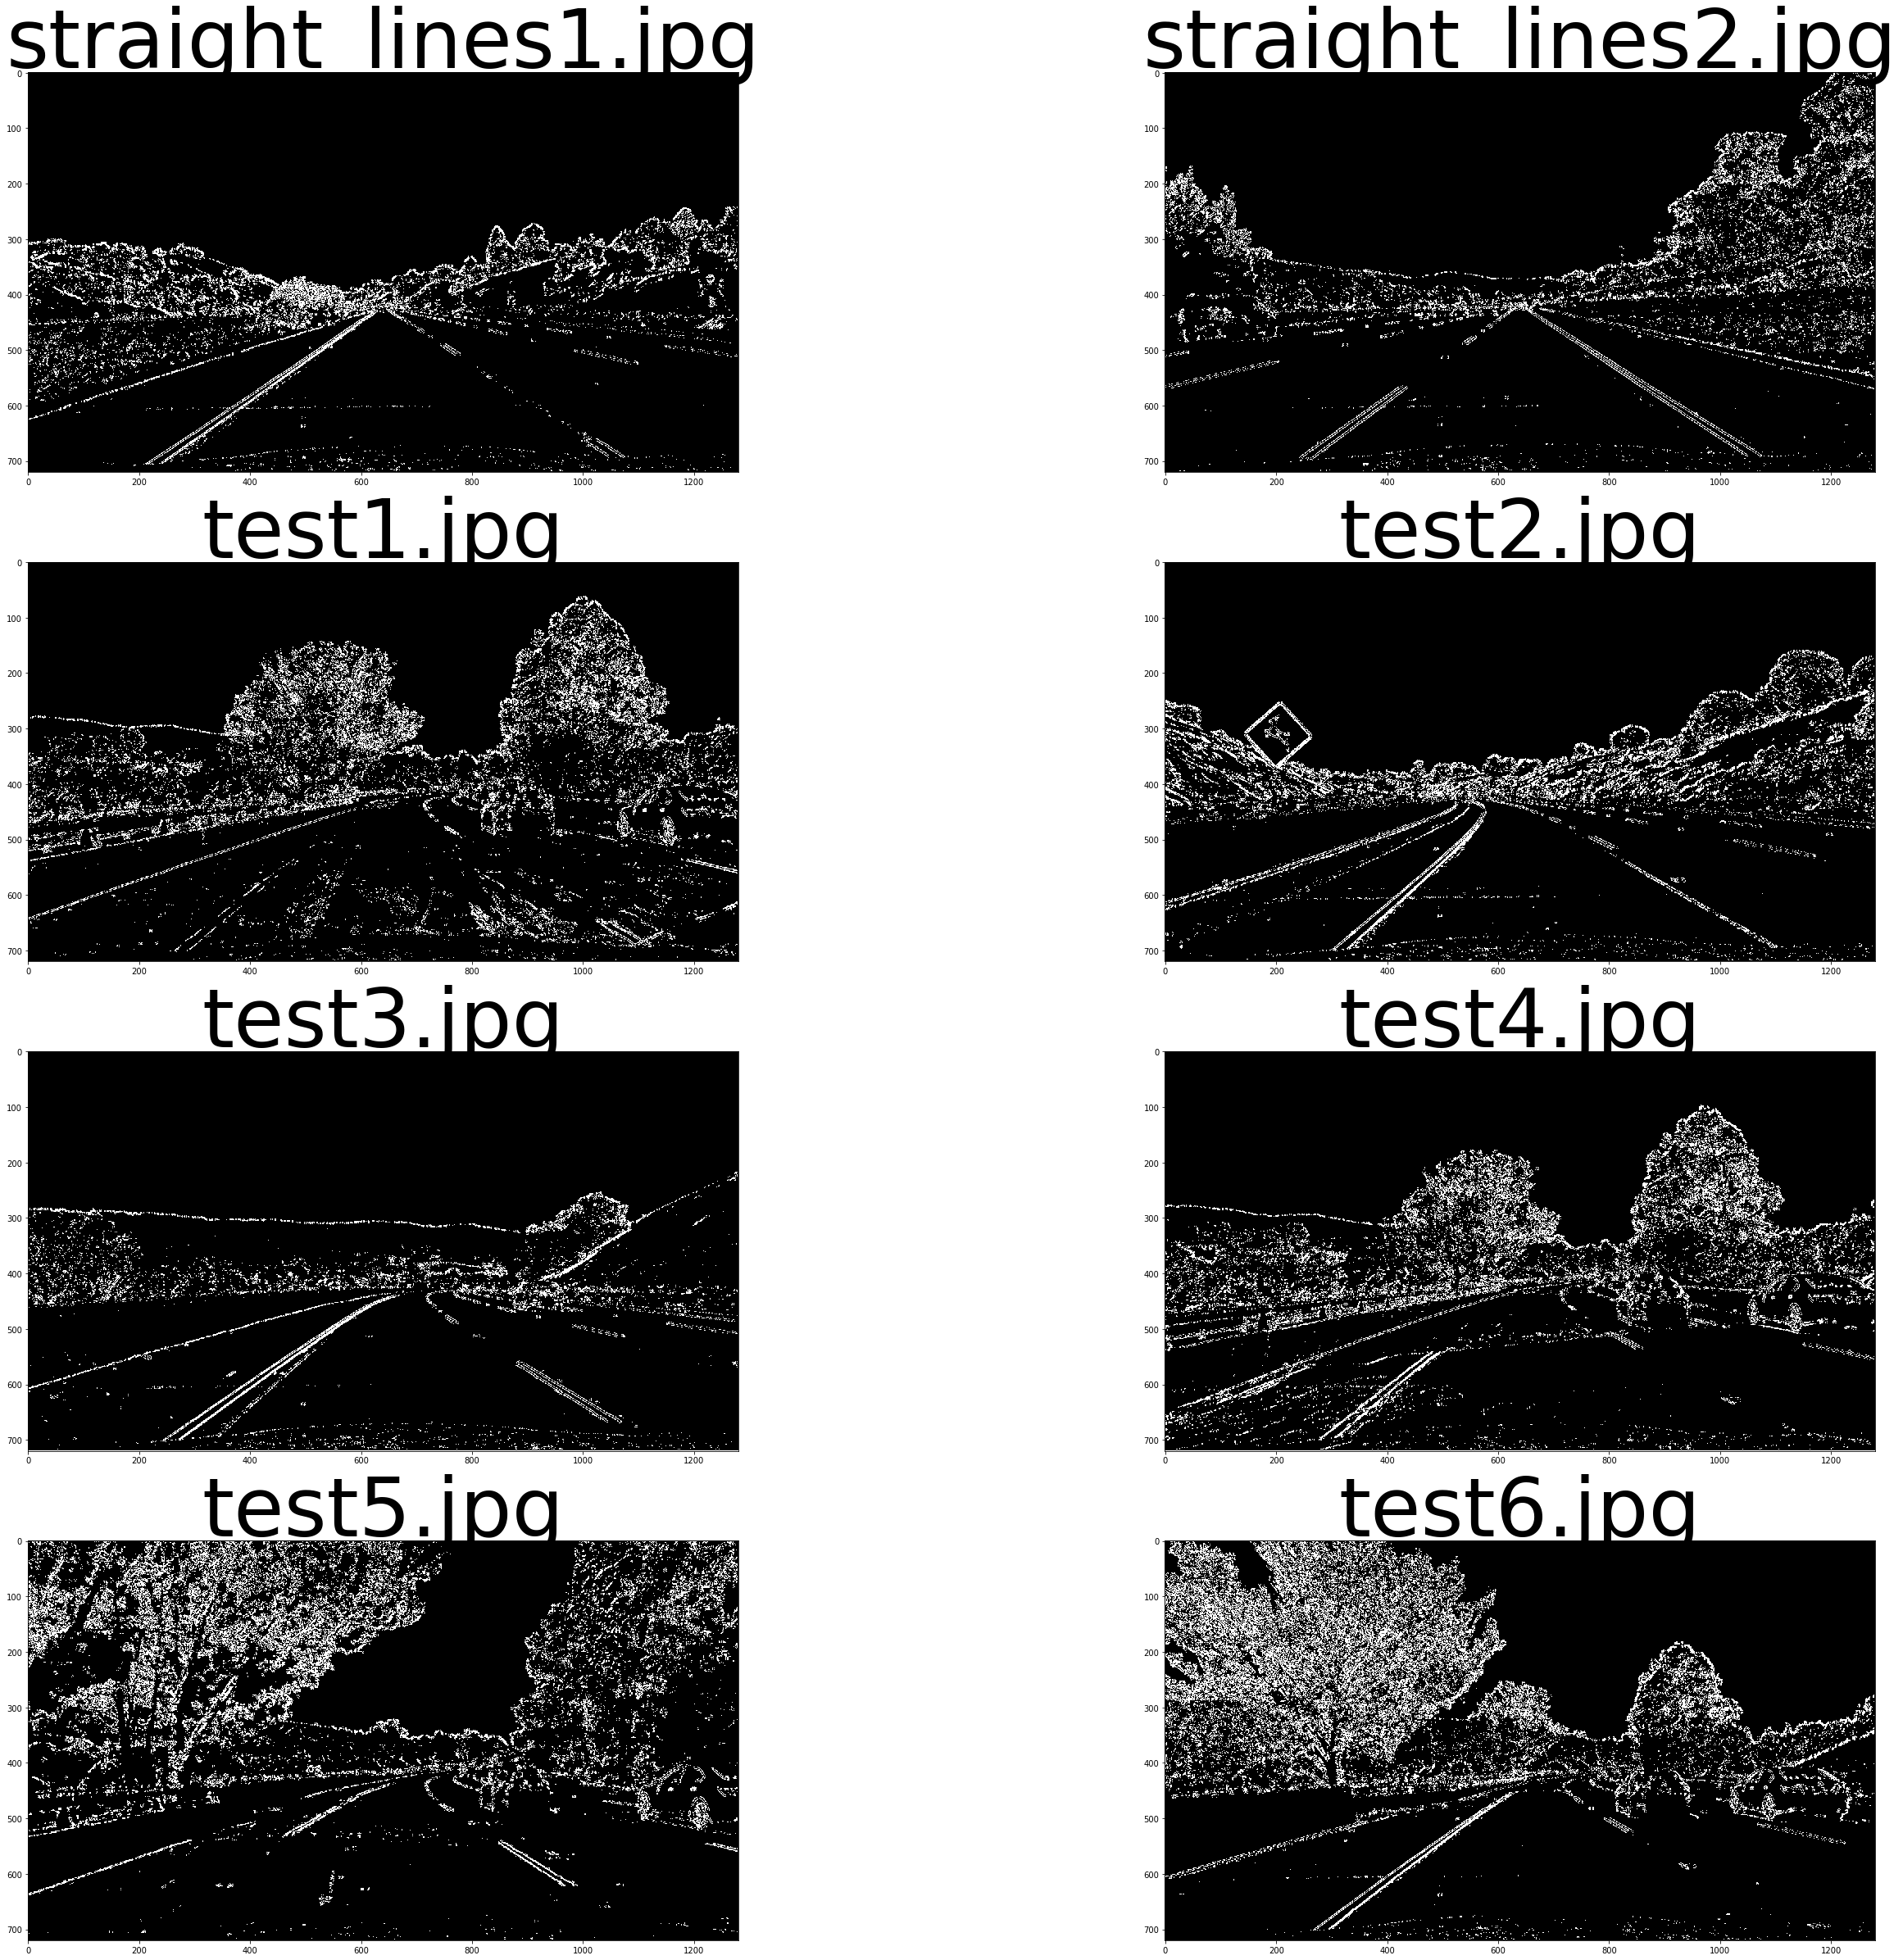

In [33]:
PATH = Path('./test_images/')
n_images = len(list(PATH.iterdir()))
print(n_images)
row_len = 2
image_width = 80/row_len

fig,axes=plt.subplots(n_images//row_len, row_len, figsize=(image_width,image_width/1.2))
for i, ax in enumerate(axes.flat):
    filename = list(PATH.iterdir())[i]
    img = plt.imread(filename)
    if img is None:
        print('ERROR')
        pdb.set_trace()
        
    img = calibrate_image(img)    
    img = gradient_sobel(img)
#     print(np.mean(img))
    
    ax.imshow(img, cmap='gray')
    ax.set_title(str(filename).split('\\')[-1], fontsize=50)
plt.tight_layout()